In [1]:
# imports
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# DCGAN adapted from github:roatienza

In [3]:
# Timer class
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [4]:
#DCGAN Class
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator, without opt and loss
        self.G = None   # generator, without opt and loss
        self.AM = None  # adversarial model with opt and loss + DM
        self.DM = None  # discriminator model with opt and loss

    # Discriminator
    # Takes in MNIST Images of 28x28x1 -> downsamples to 14x14x64 -> 7x7x128 -> 4x4x256 -> 4x4x512
    # applies stride = 2 instead of MaxPooling and adds dropout of 0.4 for stabilised learning
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4

        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Outout through sigmoid activation to squash pixel values to 0,1
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 256
        dim = 7
        # Takes in vector of random noise of size 100
        # applies Convolution Transpose and upscales repeatedly to match Discriminator convolutions but in reverse
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # inputs: dim x dim x depth 7x7x256
        # outputs: 2*dim x 2*dim x depth/2 for 14x14x128
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        # upsample repeat
        # inputs: dim x dim x depth 14x14x128
        # outputs: 2*dim x 2*dim x depth/2 for 28x28x64
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        # upsample repeat
        # inputs: dim x dim x depth 28x28x64
        # outputs: 2*dim x 2*dim x depth/2 for 28x28x32
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # final convolution layer outputs a 28 x 28 x 1 grayscale image [0.0,1.0] per pixel value
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G
    
    # D, Discriminator Model - app RMSprop optimizer and loss functions
    # Trains on MNIST Data
    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM
    
    # AM, Adversarial Model - Stack G and D and apply optimizer and loss function
    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM


In [10]:
# Define Stacked GAN and training and noise samples for D, G
# Define plotting function and save at specific training intervals

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        # load in MNIST images and reshape into 1D vectors
        self.x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        # initialise DCGAN with D, G and AM models
        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
    
    # train D and G on real and noise data
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
            

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


In [11]:
# Initialise DCGAN and Timer
mnist_dcgan = MNIST_DCGAN()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None

0: [D loss: 0.703390, acc: 0.552500]  [A loss: 0.781994, acc: 0.370000]
1: [D loss: 0.716392, acc: 0.497500]  [A loss: 0.775761, acc: 0.390000]
2: [D loss: 0.695051, acc: 0.542500]  [A loss: 0.814009, acc: 0.340000]
3: [D loss: 0.714973, acc: 0.517500]  [A loss: 0.791081, acc: 0.355000]
4: [D loss: 0.712546, acc: 0.542500]  [A loss: 0.824238, acc: 0.310000]
5: [D loss: 0.710426, acc: 0.537500]  [A loss: 0.820325, acc: 0.345000]
6: [D loss: 0.720372, acc: 0.522500]  [A loss: 0.769186, acc: 0.360000]
7: [D loss: 0.727890, acc: 0.490000]  [A loss: 0.867830, acc: 0.285000]
8: [D loss: 0.687465, acc: 0.512500]  [A loss: 0.799581, acc: 0.385000]
9: [D loss: 0.706860, acc: 0.522500]  [A loss: 0.826467, acc: 0.350000]


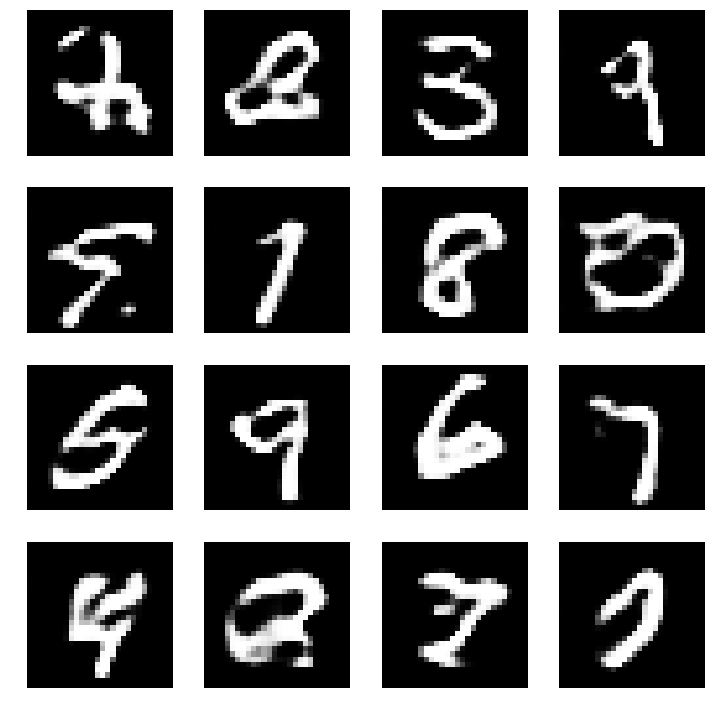

In [18]:
# Visualise Noise 
mnist_dcgan.train(train_steps=10, batch_size=200, save_interval=1)
mnist_dcgan.plot_images(fake=True, save2file=False)

0: [D loss: 0.676510, acc: 0.576172]  [A loss: 0.927176, acc: 0.070312]
1: [D loss: 0.682454, acc: 0.560547]  [A loss: 0.847062, acc: 0.171875]
2: [D loss: 0.694049, acc: 0.494141]  [A loss: 0.944294, acc: 0.070312]
3: [D loss: 0.685476, acc: 0.535156]  [A loss: 0.892463, acc: 0.109375]
4: [D loss: 0.679122, acc: 0.585938]  [A loss: 0.887934, acc: 0.101562]
5: [D loss: 0.687118, acc: 0.552734]  [A loss: 0.915107, acc: 0.136719]
6: [D loss: 0.701477, acc: 0.550781]  [A loss: 0.958487, acc: 0.042969]
7: [D loss: 0.691788, acc: 0.525391]  [A loss: 0.945148, acc: 0.050781]
8: [D loss: 0.679253, acc: 0.585938]  [A loss: 0.910327, acc: 0.109375]
9: [D loss: 0.685358, acc: 0.558594]  [A loss: 1.043645, acc: 0.023438]
10: [D loss: 0.675296, acc: 0.566406]  [A loss: 0.844653, acc: 0.187500]
11: [D loss: 0.679972, acc: 0.550781]  [A loss: 1.119424, acc: 0.011719]
12: [D loss: 0.693679, acc: 0.509766]  [A loss: 0.772725, acc: 0.269531]
13: [D loss: 0.692237, acc: 0.535156]  [A loss: 1.178445, acc

115: [D loss: 0.683729, acc: 0.554688]  [A loss: 0.867077, acc: 0.148438]
116: [D loss: 0.664465, acc: 0.601562]  [A loss: 0.835776, acc: 0.171875]
117: [D loss: 0.670764, acc: 0.564453]  [A loss: 0.925818, acc: 0.074219]
118: [D loss: 0.673695, acc: 0.585938]  [A loss: 0.853518, acc: 0.144531]
119: [D loss: 0.687208, acc: 0.544922]  [A loss: 0.938443, acc: 0.074219]
120: [D loss: 0.661379, acc: 0.601562]  [A loss: 0.791736, acc: 0.273438]
121: [D loss: 0.699408, acc: 0.531250]  [A loss: 1.124660, acc: 0.011719]
122: [D loss: 0.682032, acc: 0.572266]  [A loss: 0.647615, acc: 0.660156]
123: [D loss: 0.723821, acc: 0.507812]  [A loss: 1.097392, acc: 0.000000]
124: [D loss: 0.689093, acc: 0.548828]  [A loss: 0.687876, acc: 0.500000]
125: [D loss: 0.702351, acc: 0.531250]  [A loss: 1.012321, acc: 0.019531]
126: [D loss: 0.672300, acc: 0.582031]  [A loss: 0.726868, acc: 0.402344]
127: [D loss: 0.683525, acc: 0.537109]  [A loss: 0.971354, acc: 0.039062]
128: [D loss: 0.669593, acc: 0.578125]

227: [D loss: 0.671175, acc: 0.587891]  [A loss: 0.895107, acc: 0.121094]
228: [D loss: 0.668758, acc: 0.576172]  [A loss: 0.911885, acc: 0.093750]
229: [D loss: 0.672330, acc: 0.587891]  [A loss: 0.950281, acc: 0.062500]
230: [D loss: 0.675493, acc: 0.564453]  [A loss: 0.850724, acc: 0.132812]
231: [D loss: 0.687334, acc: 0.548828]  [A loss: 1.021948, acc: 0.023438]
232: [D loss: 0.663577, acc: 0.609375]  [A loss: 0.748131, acc: 0.390625]
233: [D loss: 0.695643, acc: 0.556641]  [A loss: 1.142660, acc: 0.003906]
234: [D loss: 0.679413, acc: 0.570312]  [A loss: 0.645078, acc: 0.667969]
235: [D loss: 0.728519, acc: 0.503906]  [A loss: 1.053333, acc: 0.035156]
236: [D loss: 0.671571, acc: 0.597656]  [A loss: 0.727091, acc: 0.398438]
237: [D loss: 0.698055, acc: 0.527344]  [A loss: 0.987099, acc: 0.035156]
238: [D loss: 0.664788, acc: 0.611328]  [A loss: 0.766818, acc: 0.312500]
239: [D loss: 0.694522, acc: 0.546875]  [A loss: 0.940079, acc: 0.070312]
240: [D loss: 0.669929, acc: 0.558594]

339: [D loss: 0.673230, acc: 0.550781]  [A loss: 0.905511, acc: 0.144531]
340: [D loss: 0.680131, acc: 0.570312]  [A loss: 1.059040, acc: 0.046875]
341: [D loss: 0.672907, acc: 0.578125]  [A loss: 0.835643, acc: 0.199219]
342: [D loss: 0.682021, acc: 0.548828]  [A loss: 1.095680, acc: 0.015625]
343: [D loss: 0.658944, acc: 0.599609]  [A loss: 0.724135, acc: 0.406250]
344: [D loss: 0.714796, acc: 0.529297]  [A loss: 1.243167, acc: 0.003906]
345: [D loss: 0.682279, acc: 0.550781]  [A loss: 0.627196, acc: 0.667969]
346: [D loss: 0.725108, acc: 0.523438]  [A loss: 1.112629, acc: 0.011719]
347: [D loss: 0.670821, acc: 0.583984]  [A loss: 0.723738, acc: 0.449219]
348: [D loss: 0.696242, acc: 0.523438]  [A loss: 1.012912, acc: 0.058594]
349: [D loss: 0.678258, acc: 0.562500]  [A loss: 0.831850, acc: 0.210938]
350: [D loss: 0.689558, acc: 0.546875]  [A loss: 0.893038, acc: 0.136719]
351: [D loss: 0.682163, acc: 0.574219]  [A loss: 0.897860, acc: 0.132812]
352: [D loss: 0.680549, acc: 0.574219]

451: [D loss: 0.681854, acc: 0.558594]  [A loss: 0.959718, acc: 0.109375]
452: [D loss: 0.682165, acc: 0.576172]  [A loss: 0.837291, acc: 0.242188]
453: [D loss: 0.676448, acc: 0.597656]  [A loss: 0.939486, acc: 0.113281]
454: [D loss: 0.669848, acc: 0.603516]  [A loss: 0.888075, acc: 0.164062]
455: [D loss: 0.675745, acc: 0.576172]  [A loss: 0.909545, acc: 0.140625]
456: [D loss: 0.691901, acc: 0.544922]  [A loss: 1.074784, acc: 0.039062]
457: [D loss: 0.670375, acc: 0.574219]  [A loss: 0.725515, acc: 0.437500]
458: [D loss: 0.704263, acc: 0.558594]  [A loss: 1.219538, acc: 0.000000]
459: [D loss: 0.685008, acc: 0.570312]  [A loss: 0.612334, acc: 0.718750]
460: [D loss: 0.745733, acc: 0.505859]  [A loss: 1.114857, acc: 0.035156]
461: [D loss: 0.677808, acc: 0.566406]  [A loss: 0.721331, acc: 0.441406]
462: [D loss: 0.709776, acc: 0.535156]  [A loss: 0.978803, acc: 0.035156]
463: [D loss: 0.680977, acc: 0.556641]  [A loss: 0.836479, acc: 0.214844]
464: [D loss: 0.676078, acc: 0.582031]

563: [D loss: 0.672625, acc: 0.572266]  [A loss: 0.822405, acc: 0.234375]
564: [D loss: 0.715343, acc: 0.544922]  [A loss: 0.980920, acc: 0.062500]
565: [D loss: 0.686872, acc: 0.535156]  [A loss: 0.905757, acc: 0.125000]
566: [D loss: 0.701862, acc: 0.546875]  [A loss: 0.953240, acc: 0.089844]
567: [D loss: 0.657082, acc: 0.617188]  [A loss: 0.916529, acc: 0.140625]
568: [D loss: 0.688524, acc: 0.539062]  [A loss: 0.919976, acc: 0.101562]
569: [D loss: 0.673147, acc: 0.583984]  [A loss: 0.915764, acc: 0.105469]
570: [D loss: 0.682421, acc: 0.552734]  [A loss: 0.864994, acc: 0.199219]
571: [D loss: 0.700429, acc: 0.533203]  [A loss: 0.977358, acc: 0.058594]
572: [D loss: 0.680078, acc: 0.554688]  [A loss: 0.853998, acc: 0.199219]
573: [D loss: 0.679827, acc: 0.541016]  [A loss: 1.008901, acc: 0.062500]
574: [D loss: 0.689250, acc: 0.542969]  [A loss: 0.793558, acc: 0.320312]
575: [D loss: 0.710128, acc: 0.511719]  [A loss: 1.133380, acc: 0.035156]
576: [D loss: 0.663768, acc: 0.599609]

675: [D loss: 0.699358, acc: 0.535156]  [A loss: 1.058161, acc: 0.058594]
676: [D loss: 0.685066, acc: 0.537109]  [A loss: 0.824678, acc: 0.261719]
677: [D loss: 0.683753, acc: 0.583984]  [A loss: 0.938215, acc: 0.148438]
678: [D loss: 0.700943, acc: 0.523438]  [A loss: 0.855880, acc: 0.218750]
679: [D loss: 0.693369, acc: 0.537109]  [A loss: 0.975666, acc: 0.105469]
680: [D loss: 0.675957, acc: 0.570312]  [A loss: 0.861660, acc: 0.257812]
681: [D loss: 0.688109, acc: 0.554688]  [A loss: 1.013181, acc: 0.070312]
682: [D loss: 0.690238, acc: 0.541016]  [A loss: 0.773725, acc: 0.367188]
683: [D loss: 0.688653, acc: 0.542969]  [A loss: 1.071283, acc: 0.062500]
684: [D loss: 0.678367, acc: 0.560547]  [A loss: 0.714793, acc: 0.476562]
685: [D loss: 0.695390, acc: 0.544922]  [A loss: 1.142198, acc: 0.050781]
686: [D loss: 0.669247, acc: 0.585938]  [A loss: 0.659173, acc: 0.582031]
687: [D loss: 0.725690, acc: 0.515625]  [A loss: 1.049375, acc: 0.085938]
688: [D loss: 0.676901, acc: 0.583984]

787: [D loss: 0.674306, acc: 0.572266]  [A loss: 0.817871, acc: 0.250000]
788: [D loss: 0.688847, acc: 0.554688]  [A loss: 1.017486, acc: 0.050781]
789: [D loss: 0.675714, acc: 0.544922]  [A loss: 0.751211, acc: 0.363281]
790: [D loss: 0.691755, acc: 0.546875]  [A loss: 1.088260, acc: 0.046875]
791: [D loss: 0.679352, acc: 0.566406]  [A loss: 0.699444, acc: 0.500000]
792: [D loss: 0.718333, acc: 0.509766]  [A loss: 1.118343, acc: 0.035156]
793: [D loss: 0.671796, acc: 0.585938]  [A loss: 0.747328, acc: 0.441406]
794: [D loss: 0.693291, acc: 0.564453]  [A loss: 0.951890, acc: 0.093750]
795: [D loss: 0.690979, acc: 0.550781]  [A loss: 0.803024, acc: 0.312500]
796: [D loss: 0.700542, acc: 0.542969]  [A loss: 0.953758, acc: 0.101562]
797: [D loss: 0.695354, acc: 0.539062]  [A loss: 0.776056, acc: 0.355469]
798: [D loss: 0.700055, acc: 0.560547]  [A loss: 1.095256, acc: 0.062500]
799: [D loss: 0.692566, acc: 0.554688]  [A loss: 0.718816, acc: 0.460938]
800: [D loss: 0.696261, acc: 0.556641]

899: [D loss: 0.674580, acc: 0.578125]  [A loss: 0.997738, acc: 0.109375]
900: [D loss: 0.674187, acc: 0.572266]  [A loss: 0.726540, acc: 0.457031]
901: [D loss: 0.698216, acc: 0.529297]  [A loss: 1.202807, acc: 0.031250]
902: [D loss: 0.701540, acc: 0.552734]  [A loss: 0.652590, acc: 0.601562]
903: [D loss: 0.742270, acc: 0.509766]  [A loss: 1.069615, acc: 0.066406]
904: [D loss: 0.665969, acc: 0.597656]  [A loss: 0.748553, acc: 0.386719]
905: [D loss: 0.699185, acc: 0.531250]  [A loss: 0.928162, acc: 0.132812]
906: [D loss: 0.681982, acc: 0.558594]  [A loss: 0.833494, acc: 0.281250]
907: [D loss: 0.686236, acc: 0.558594]  [A loss: 0.833634, acc: 0.250000]
908: [D loss: 0.699792, acc: 0.525391]  [A loss: 0.902892, acc: 0.164062]
909: [D loss: 0.685425, acc: 0.554688]  [A loss: 0.884381, acc: 0.199219]
910: [D loss: 0.693701, acc: 0.554688]  [A loss: 0.922529, acc: 0.171875]
911: [D loss: 0.680678, acc: 0.542969]  [A loss: 0.874934, acc: 0.222656]
912: [D loss: 0.690836, acc: 0.556641]

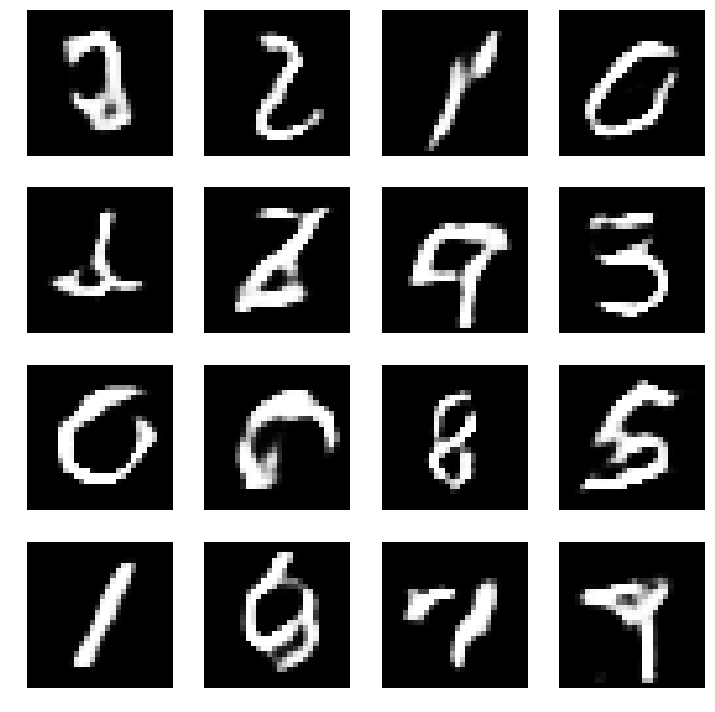

In [8]:
# Train for 1000 epochs and save at 100 intervals
# print G images
# save images
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=100)
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

0: [D loss: 0.668090, acc: 0.580078]  [A loss: 0.728395, acc: 0.464844]
1: [D loss: 0.694327, acc: 0.558594]  [A loss: 0.957397, acc: 0.109375]
2: [D loss: 0.689644, acc: 0.560547]  [A loss: 0.776072, acc: 0.359375]
3: [D loss: 0.687651, acc: 0.527344]  [A loss: 1.032217, acc: 0.082031]
4: [D loss: 0.676154, acc: 0.574219]  [A loss: 0.760045, acc: 0.410156]
5: [D loss: 0.707637, acc: 0.535156]  [A loss: 0.953330, acc: 0.121094]
6: [D loss: 0.660298, acc: 0.621094]  [A loss: 0.819997, acc: 0.292969]
7: [D loss: 0.678575, acc: 0.548828]  [A loss: 0.939528, acc: 0.156250]
8: [D loss: 0.676732, acc: 0.595703]  [A loss: 0.839849, acc: 0.203125]
9: [D loss: 0.688143, acc: 0.537109]  [A loss: 0.904341, acc: 0.179688]
10: [D loss: 0.692000, acc: 0.556641]  [A loss: 0.944440, acc: 0.148438]
11: [D loss: 0.682532, acc: 0.564453]  [A loss: 0.856599, acc: 0.242188]
12: [D loss: 0.702109, acc: 0.529297]  [A loss: 0.970112, acc: 0.089844]
13: [D loss: 0.668507, acc: 0.583984]  [A loss: 0.886611, acc

113: [D loss: 0.677893, acc: 0.572266]  [A loss: 0.856291, acc: 0.222656]
114: [D loss: 0.688014, acc: 0.556641]  [A loss: 0.935318, acc: 0.132812]
115: [D loss: 0.685481, acc: 0.564453]  [A loss: 0.876294, acc: 0.187500]
116: [D loss: 0.674746, acc: 0.580078]  [A loss: 0.862453, acc: 0.230469]
117: [D loss: 0.711542, acc: 0.505859]  [A loss: 0.885852, acc: 0.175781]
118: [D loss: 0.692854, acc: 0.570312]  [A loss: 0.920363, acc: 0.167969]
119: [D loss: 0.698082, acc: 0.546875]  [A loss: 0.839432, acc: 0.257812]
120: [D loss: 0.704180, acc: 0.515625]  [A loss: 0.958950, acc: 0.105469]
121: [D loss: 0.669245, acc: 0.583984]  [A loss: 0.799800, acc: 0.351562]
122: [D loss: 0.701054, acc: 0.537109]  [A loss: 0.994728, acc: 0.097656]
123: [D loss: 0.677974, acc: 0.591797]  [A loss: 0.759847, acc: 0.406250]
124: [D loss: 0.713397, acc: 0.515625]  [A loss: 1.038977, acc: 0.089844]
125: [D loss: 0.674996, acc: 0.570312]  [A loss: 0.686765, acc: 0.515625]
126: [D loss: 0.717894, acc: 0.525391]

224: [D loss: 0.664574, acc: 0.603516]  [A loss: 0.736762, acc: 0.437500]
225: [D loss: 0.692342, acc: 0.544922]  [A loss: 0.953597, acc: 0.113281]
226: [D loss: 0.697309, acc: 0.509766]  [A loss: 0.765792, acc: 0.351562]
227: [D loss: 0.695272, acc: 0.535156]  [A loss: 0.882610, acc: 0.207031]
228: [D loss: 0.680572, acc: 0.580078]  [A loss: 0.803922, acc: 0.281250]
229: [D loss: 0.701832, acc: 0.535156]  [A loss: 0.919088, acc: 0.183594]
230: [D loss: 0.692172, acc: 0.576172]  [A loss: 0.832827, acc: 0.277344]
231: [D loss: 0.695020, acc: 0.564453]  [A loss: 1.027460, acc: 0.078125]
232: [D loss: 0.690860, acc: 0.548828]  [A loss: 0.674241, acc: 0.593750]
233: [D loss: 0.705528, acc: 0.525391]  [A loss: 1.009466, acc: 0.101562]
234: [D loss: 0.667598, acc: 0.591797]  [A loss: 0.762600, acc: 0.398438]
235: [D loss: 0.686470, acc: 0.556641]  [A loss: 0.966195, acc: 0.105469]
236: [D loss: 0.685773, acc: 0.554688]  [A loss: 0.712556, acc: 0.480469]
237: [D loss: 0.711950, acc: 0.511719]

335: [D loss: 0.687853, acc: 0.568359]  [A loss: 0.777139, acc: 0.316406]
336: [D loss: 0.703183, acc: 0.517578]  [A loss: 1.037040, acc: 0.101562]
337: [D loss: 0.685336, acc: 0.564453]  [A loss: 0.709512, acc: 0.488281]
338: [D loss: 0.686759, acc: 0.560547]  [A loss: 0.917395, acc: 0.179688]
339: [D loss: 0.677903, acc: 0.568359]  [A loss: 0.789671, acc: 0.339844]
340: [D loss: 0.681247, acc: 0.562500]  [A loss: 0.870312, acc: 0.203125]
341: [D loss: 0.702190, acc: 0.525391]  [A loss: 0.809745, acc: 0.296875]
342: [D loss: 0.693947, acc: 0.539062]  [A loss: 0.947172, acc: 0.113281]
343: [D loss: 0.686812, acc: 0.541016]  [A loss: 0.753005, acc: 0.371094]
344: [D loss: 0.706476, acc: 0.529297]  [A loss: 0.934899, acc: 0.117188]
345: [D loss: 0.685236, acc: 0.556641]  [A loss: 0.781853, acc: 0.351562]
346: [D loss: 0.701401, acc: 0.517578]  [A loss: 0.899064, acc: 0.148438]
347: [D loss: 0.695356, acc: 0.521484]  [A loss: 0.890066, acc: 0.160156]
348: [D loss: 0.686770, acc: 0.558594]

448: [D loss: 0.693419, acc: 0.535156]  [A loss: 0.761629, acc: 0.367188]
449: [D loss: 0.692602, acc: 0.556641]  [A loss: 0.913591, acc: 0.156250]
450: [D loss: 0.675563, acc: 0.587891]  [A loss: 0.783466, acc: 0.355469]
451: [D loss: 0.681560, acc: 0.542969]  [A loss: 0.888405, acc: 0.175781]
452: [D loss: 0.686233, acc: 0.515625]  [A loss: 0.800643, acc: 0.253906]
453: [D loss: 0.697550, acc: 0.517578]  [A loss: 0.918673, acc: 0.152344]
454: [D loss: 0.686726, acc: 0.548828]  [A loss: 0.856974, acc: 0.222656]
455: [D loss: 0.709297, acc: 0.505859]  [A loss: 0.848750, acc: 0.191406]
456: [D loss: 0.695824, acc: 0.544922]  [A loss: 0.940321, acc: 0.125000]
457: [D loss: 0.701499, acc: 0.521484]  [A loss: 0.723380, acc: 0.468750]
458: [D loss: 0.720771, acc: 0.501953]  [A loss: 1.031152, acc: 0.054688]
459: [D loss: 0.685491, acc: 0.550781]  [A loss: 0.683120, acc: 0.507812]
460: [D loss: 0.716022, acc: 0.525391]  [A loss: 0.946399, acc: 0.113281]
461: [D loss: 0.681274, acc: 0.560547]

559: [D loss: 0.686899, acc: 0.566406]  [A loss: 0.754179, acc: 0.386719]
560: [D loss: 0.698264, acc: 0.525391]  [A loss: 0.899351, acc: 0.132812]
561: [D loss: 0.671211, acc: 0.580078]  [A loss: 0.828891, acc: 0.218750]
562: [D loss: 0.695293, acc: 0.539062]  [A loss: 0.867600, acc: 0.164062]
563: [D loss: 0.695971, acc: 0.548828]  [A loss: 0.847094, acc: 0.238281]
564: [D loss: 0.693605, acc: 0.535156]  [A loss: 0.842684, acc: 0.164062]
565: [D loss: 0.703434, acc: 0.539062]  [A loss: 0.902956, acc: 0.128906]
566: [D loss: 0.686744, acc: 0.568359]  [A loss: 0.797244, acc: 0.281250]
567: [D loss: 0.692663, acc: 0.564453]  [A loss: 0.862992, acc: 0.175781]
568: [D loss: 0.694568, acc: 0.537109]  [A loss: 0.810221, acc: 0.292969]
569: [D loss: 0.704407, acc: 0.535156]  [A loss: 0.974279, acc: 0.085938]
570: [D loss: 0.689823, acc: 0.519531]  [A loss: 0.792121, acc: 0.289062]
571: [D loss: 0.693333, acc: 0.527344]  [A loss: 0.963444, acc: 0.082031]
572: [D loss: 0.673430, acc: 0.558594]

672: [D loss: 0.702325, acc: 0.537109]  [A loss: 0.971405, acc: 0.078125]
673: [D loss: 0.698992, acc: 0.498047]  [A loss: 0.710358, acc: 0.472656]
674: [D loss: 0.702851, acc: 0.519531]  [A loss: 0.917505, acc: 0.148438]
675: [D loss: 0.700723, acc: 0.529297]  [A loss: 0.775658, acc: 0.343750]
676: [D loss: 0.685557, acc: 0.560547]  [A loss: 0.832374, acc: 0.269531]
677: [D loss: 0.686862, acc: 0.544922]  [A loss: 0.789268, acc: 0.328125]
678: [D loss: 0.698396, acc: 0.539062]  [A loss: 0.877815, acc: 0.164062]
679: [D loss: 0.690748, acc: 0.535156]  [A loss: 0.828154, acc: 0.214844]
680: [D loss: 0.689013, acc: 0.556641]  [A loss: 0.792301, acc: 0.335938]
681: [D loss: 0.701961, acc: 0.539062]  [A loss: 0.933023, acc: 0.101562]
682: [D loss: 0.692360, acc: 0.537109]  [A loss: 0.735812, acc: 0.390625]
683: [D loss: 0.698735, acc: 0.527344]  [A loss: 0.963985, acc: 0.082031]
684: [D loss: 0.682872, acc: 0.566406]  [A loss: 0.711233, acc: 0.484375]
685: [D loss: 0.716470, acc: 0.521484]

783: [D loss: 0.671938, acc: 0.597656]  [A loss: 0.722044, acc: 0.445312]
784: [D loss: 0.706946, acc: 0.503906]  [A loss: 0.943255, acc: 0.113281]
785: [D loss: 0.685975, acc: 0.527344]  [A loss: 0.685410, acc: 0.546875]
786: [D loss: 0.712200, acc: 0.533203]  [A loss: 0.940622, acc: 0.128906]
787: [D loss: 0.697868, acc: 0.486328]  [A loss: 0.779093, acc: 0.335938]
788: [D loss: 0.724266, acc: 0.470703]  [A loss: 0.855409, acc: 0.156250]
789: [D loss: 0.696604, acc: 0.535156]  [A loss: 0.822607, acc: 0.226562]
790: [D loss: 0.676617, acc: 0.580078]  [A loss: 0.760656, acc: 0.351562]
791: [D loss: 0.702124, acc: 0.539062]  [A loss: 0.927726, acc: 0.105469]
792: [D loss: 0.693369, acc: 0.537109]  [A loss: 0.767889, acc: 0.347656]
793: [D loss: 0.704713, acc: 0.503906]  [A loss: 0.872146, acc: 0.152344]
794: [D loss: 0.696070, acc: 0.523438]  [A loss: 0.781742, acc: 0.316406]
795: [D loss: 0.689536, acc: 0.572266]  [A loss: 0.853420, acc: 0.218750]
796: [D loss: 0.713211, acc: 0.484375]

896: [D loss: 0.688301, acc: 0.541016]  [A loss: 0.806214, acc: 0.250000]
897: [D loss: 0.697920, acc: 0.525391]  [A loss: 0.868556, acc: 0.191406]
898: [D loss: 0.696711, acc: 0.537109]  [A loss: 0.787628, acc: 0.277344]
899: [D loss: 0.691261, acc: 0.521484]  [A loss: 0.809578, acc: 0.289062]
900: [D loss: 0.697690, acc: 0.509766]  [A loss: 0.889564, acc: 0.128906]
901: [D loss: 0.686948, acc: 0.529297]  [A loss: 0.763477, acc: 0.386719]
902: [D loss: 0.715947, acc: 0.509766]  [A loss: 0.959382, acc: 0.070312]
903: [D loss: 0.684043, acc: 0.562500]  [A loss: 0.710276, acc: 0.460938]
904: [D loss: 0.702879, acc: 0.541016]  [A loss: 0.935858, acc: 0.082031]
905: [D loss: 0.690506, acc: 0.539062]  [A loss: 0.774344, acc: 0.351562]
906: [D loss: 0.698668, acc: 0.507812]  [A loss: 0.816956, acc: 0.242188]
907: [D loss: 0.696024, acc: 0.556641]  [A loss: 0.840512, acc: 0.203125]
908: [D loss: 0.695016, acc: 0.548828]  [A loss: 0.804074, acc: 0.261719]
909: [D loss: 0.688095, acc: 0.529297]

1009: [D loss: 0.695051, acc: 0.535156]  [A loss: 0.800250, acc: 0.277344]
1010: [D loss: 0.676206, acc: 0.548828]  [A loss: 0.808577, acc: 0.257812]
1011: [D loss: 0.696402, acc: 0.525391]  [A loss: 0.901071, acc: 0.128906]
1012: [D loss: 0.696815, acc: 0.500000]  [A loss: 0.779147, acc: 0.351562]
1013: [D loss: 0.700291, acc: 0.523438]  [A loss: 0.854357, acc: 0.195312]
1014: [D loss: 0.704539, acc: 0.486328]  [A loss: 0.811046, acc: 0.285156]
1015: [D loss: 0.693936, acc: 0.523438]  [A loss: 0.752581, acc: 0.386719]
1016: [D loss: 0.717485, acc: 0.503906]  [A loss: 0.956222, acc: 0.082031]
1017: [D loss: 0.679933, acc: 0.560547]  [A loss: 0.703342, acc: 0.531250]
1018: [D loss: 0.715180, acc: 0.531250]  [A loss: 0.953397, acc: 0.082031]
1019: [D loss: 0.694212, acc: 0.527344]  [A loss: 0.740686, acc: 0.410156]
1020: [D loss: 0.694880, acc: 0.533203]  [A loss: 0.860994, acc: 0.191406]
1021: [D loss: 0.703887, acc: 0.511719]  [A loss: 0.809492, acc: 0.253906]
1022: [D loss: 0.699681, 

1120: [D loss: 0.694568, acc: 0.544922]  [A loss: 0.926248, acc: 0.113281]
1121: [D loss: 0.689877, acc: 0.523438]  [A loss: 0.734940, acc: 0.410156]
1122: [D loss: 0.701266, acc: 0.552734]  [A loss: 0.905387, acc: 0.113281]
1123: [D loss: 0.689037, acc: 0.548828]  [A loss: 0.708187, acc: 0.507812]
1124: [D loss: 0.700221, acc: 0.531250]  [A loss: 0.897633, acc: 0.136719]
1125: [D loss: 0.709963, acc: 0.521484]  [A loss: 0.775653, acc: 0.312500]
1126: [D loss: 0.702894, acc: 0.546875]  [A loss: 0.962493, acc: 0.097656]
1127: [D loss: 0.697124, acc: 0.505859]  [A loss: 0.669843, acc: 0.593750]
1128: [D loss: 0.720304, acc: 0.527344]  [A loss: 0.968299, acc: 0.070312]
1129: [D loss: 0.691568, acc: 0.544922]  [A loss: 0.715150, acc: 0.449219]
1130: [D loss: 0.716442, acc: 0.521484]  [A loss: 0.908583, acc: 0.132812]
1131: [D loss: 0.696066, acc: 0.521484]  [A loss: 0.733934, acc: 0.437500]
1132: [D loss: 0.715691, acc: 0.513672]  [A loss: 0.849780, acc: 0.226562]
1133: [D loss: 0.709510, 

1230: [D loss: 0.709045, acc: 0.492188]  [A loss: 0.810815, acc: 0.277344]
1231: [D loss: 0.697675, acc: 0.527344]  [A loss: 0.873804, acc: 0.179688]
1232: [D loss: 0.711265, acc: 0.478516]  [A loss: 0.802182, acc: 0.285156]
1233: [D loss: 0.700574, acc: 0.509766]  [A loss: 0.874488, acc: 0.152344]
1234: [D loss: 0.694124, acc: 0.527344]  [A loss: 0.826034, acc: 0.214844]
1235: [D loss: 0.710664, acc: 0.523438]  [A loss: 0.963978, acc: 0.085938]
1236: [D loss: 0.706341, acc: 0.523438]  [A loss: 0.694875, acc: 0.515625]
1237: [D loss: 0.705455, acc: 0.523438]  [A loss: 0.980866, acc: 0.085938]
1238: [D loss: 0.701483, acc: 0.517578]  [A loss: 0.664618, acc: 0.585938]
1239: [D loss: 0.725836, acc: 0.507812]  [A loss: 0.985820, acc: 0.078125]
1240: [D loss: 0.700815, acc: 0.511719]  [A loss: 0.722301, acc: 0.445312]
1241: [D loss: 0.706692, acc: 0.517578]  [A loss: 0.827586, acc: 0.226562]
1242: [D loss: 0.683008, acc: 0.572266]  [A loss: 0.782381, acc: 0.300781]
1243: [D loss: 0.690216, 

1341: [D loss: 0.700695, acc: 0.517578]  [A loss: 0.857126, acc: 0.207031]
1342: [D loss: 0.686450, acc: 0.556641]  [A loss: 0.817956, acc: 0.218750]
1343: [D loss: 0.701854, acc: 0.525391]  [A loss: 0.788917, acc: 0.304688]
1344: [D loss: 0.690489, acc: 0.556641]  [A loss: 0.868134, acc: 0.199219]
1345: [D loss: 0.695478, acc: 0.542969]  [A loss: 0.775326, acc: 0.351562]
1346: [D loss: 0.698071, acc: 0.564453]  [A loss: 0.911434, acc: 0.113281]
1347: [D loss: 0.687350, acc: 0.509766]  [A loss: 0.758076, acc: 0.421875]
1348: [D loss: 0.699461, acc: 0.533203]  [A loss: 0.847911, acc: 0.226562]
1349: [D loss: 0.700516, acc: 0.517578]  [A loss: 0.735563, acc: 0.460938]
1350: [D loss: 0.710009, acc: 0.539062]  [A loss: 0.950441, acc: 0.113281]
1351: [D loss: 0.701796, acc: 0.519531]  [A loss: 0.693443, acc: 0.550781]
1352: [D loss: 0.720222, acc: 0.509766]  [A loss: 1.013639, acc: 0.070312]
1353: [D loss: 0.697744, acc: 0.515625]  [A loss: 0.673573, acc: 0.566406]
1354: [D loss: 0.715158, 

1451: [D loss: 0.714624, acc: 0.505859]  [A loss: 0.925239, acc: 0.125000]
1452: [D loss: 0.703130, acc: 0.515625]  [A loss: 0.748724, acc: 0.375000]
1453: [D loss: 0.708731, acc: 0.513672]  [A loss: 0.877599, acc: 0.191406]
1454: [D loss: 0.687757, acc: 0.568359]  [A loss: 0.762089, acc: 0.355469]
1455: [D loss: 0.702864, acc: 0.533203]  [A loss: 0.858401, acc: 0.183594]
1456: [D loss: 0.698910, acc: 0.542969]  [A loss: 0.773688, acc: 0.363281]
1457: [D loss: 0.716406, acc: 0.500000]  [A loss: 0.876767, acc: 0.160156]
1458: [D loss: 0.682079, acc: 0.593750]  [A loss: 0.833169, acc: 0.246094]
1459: [D loss: 0.711117, acc: 0.500000]  [A loss: 0.888361, acc: 0.164062]
1460: [D loss: 0.695745, acc: 0.535156]  [A loss: 0.746831, acc: 0.378906]
1461: [D loss: 0.714111, acc: 0.533203]  [A loss: 0.940918, acc: 0.113281]
1462: [D loss: 0.692810, acc: 0.531250]  [A loss: 0.737109, acc: 0.414062]
1463: [D loss: 0.707080, acc: 0.523438]  [A loss: 0.977501, acc: 0.105469]
1464: [D loss: 0.692146, 

1562: [D loss: 0.701383, acc: 0.523438]  [A loss: 0.685439, acc: 0.535156]
1563: [D loss: 0.722842, acc: 0.519531]  [A loss: 0.925203, acc: 0.128906]
1564: [D loss: 0.697235, acc: 0.503906]  [A loss: 0.781131, acc: 0.335938]
1565: [D loss: 0.687431, acc: 0.558594]  [A loss: 0.810846, acc: 0.277344]
1566: [D loss: 0.688563, acc: 0.552734]  [A loss: 0.813756, acc: 0.273438]
1567: [D loss: 0.705485, acc: 0.511719]  [A loss: 0.887202, acc: 0.160156]
1568: [D loss: 0.695063, acc: 0.517578]  [A loss: 0.785420, acc: 0.312500]
1569: [D loss: 0.698685, acc: 0.531250]  [A loss: 0.966102, acc: 0.070312]
1570: [D loss: 0.696854, acc: 0.509766]  [A loss: 0.829598, acc: 0.234375]
1571: [D loss: 0.712948, acc: 0.525391]  [A loss: 0.888531, acc: 0.179688]
1572: [D loss: 0.681822, acc: 0.552734]  [A loss: 0.757445, acc: 0.414062]
1573: [D loss: 0.705442, acc: 0.513672]  [A loss: 0.940862, acc: 0.117188]
1574: [D loss: 0.692205, acc: 0.531250]  [A loss: 0.696940, acc: 0.500000]
1575: [D loss: 0.714628, 

1672: [D loss: 0.684608, acc: 0.570312]  [A loss: 0.685761, acc: 0.539062]
1673: [D loss: 0.713877, acc: 0.531250]  [A loss: 1.015275, acc: 0.046875]
1674: [D loss: 0.700071, acc: 0.544922]  [A loss: 0.686670, acc: 0.535156]
1675: [D loss: 0.725457, acc: 0.507812]  [A loss: 0.927671, acc: 0.160156]
1676: [D loss: 0.703876, acc: 0.515625]  [A loss: 0.734733, acc: 0.433594]
1677: [D loss: 0.716785, acc: 0.519531]  [A loss: 0.879035, acc: 0.203125]
1678: [D loss: 0.698971, acc: 0.537109]  [A loss: 0.766438, acc: 0.386719]
1679: [D loss: 0.707169, acc: 0.527344]  [A loss: 0.829070, acc: 0.210938]
1680: [D loss: 0.701564, acc: 0.494141]  [A loss: 0.879254, acc: 0.171875]
1681: [D loss: 0.712636, acc: 0.519531]  [A loss: 0.803922, acc: 0.250000]
1682: [D loss: 0.694570, acc: 0.550781]  [A loss: 0.848105, acc: 0.214844]
1683: [D loss: 0.690949, acc: 0.517578]  [A loss: 0.813465, acc: 0.257812]
1684: [D loss: 0.713809, acc: 0.472656]  [A loss: 0.835829, acc: 0.207031]
1685: [D loss: 0.712955, 

1783: [D loss: 0.751044, acc: 0.517578]  [A loss: 0.973238, acc: 0.109375]
1784: [D loss: 0.701646, acc: 0.490234]  [A loss: 0.694144, acc: 0.546875]
1785: [D loss: 0.724049, acc: 0.494141]  [A loss: 0.862494, acc: 0.207031]
1786: [D loss: 0.693513, acc: 0.552734]  [A loss: 0.790268, acc: 0.292969]
1787: [D loss: 0.686816, acc: 0.578125]  [A loss: 0.853024, acc: 0.203125]
1788: [D loss: 0.686933, acc: 0.560547]  [A loss: 0.826194, acc: 0.242188]
1789: [D loss: 0.710865, acc: 0.519531]  [A loss: 0.818490, acc: 0.273438]
1790: [D loss: 0.709722, acc: 0.500000]  [A loss: 0.869894, acc: 0.214844]
1791: [D loss: 0.720315, acc: 0.490234]  [A loss: 0.817041, acc: 0.277344]
1792: [D loss: 0.701796, acc: 0.521484]  [A loss: 0.797275, acc: 0.324219]
1793: [D loss: 0.699080, acc: 0.529297]  [A loss: 0.807741, acc: 0.296875]
1794: [D loss: 0.690897, acc: 0.554688]  [A loss: 0.849414, acc: 0.210938]
1795: [D loss: 0.695044, acc: 0.544922]  [A loss: 0.797930, acc: 0.285156]
1796: [D loss: 0.711336, 

1893: [D loss: 0.697217, acc: 0.541016]  [A loss: 0.795991, acc: 0.304688]
1894: [D loss: 0.711483, acc: 0.529297]  [A loss: 0.886300, acc: 0.175781]
1895: [D loss: 0.701584, acc: 0.542969]  [A loss: 0.862261, acc: 0.218750]
1896: [D loss: 0.702549, acc: 0.535156]  [A loss: 0.778061, acc: 0.375000]
1897: [D loss: 0.705870, acc: 0.490234]  [A loss: 0.927968, acc: 0.156250]
1898: [D loss: 0.699569, acc: 0.515625]  [A loss: 0.775148, acc: 0.367188]
1899: [D loss: 0.704102, acc: 0.517578]  [A loss: 0.920981, acc: 0.152344]
1900: [D loss: 0.711657, acc: 0.509766]  [A loss: 0.802379, acc: 0.312500]
1901: [D loss: 0.696442, acc: 0.517578]  [A loss: 0.893804, acc: 0.164062]
1902: [D loss: 0.687439, acc: 0.562500]  [A loss: 0.794887, acc: 0.335938]
1903: [D loss: 0.705943, acc: 0.505859]  [A loss: 0.894863, acc: 0.187500]
1904: [D loss: 0.676472, acc: 0.546875]  [A loss: 0.799974, acc: 0.320312]
1905: [D loss: 0.700638, acc: 0.554688]  [A loss: 0.928632, acc: 0.160156]
1906: [D loss: 0.682297, 

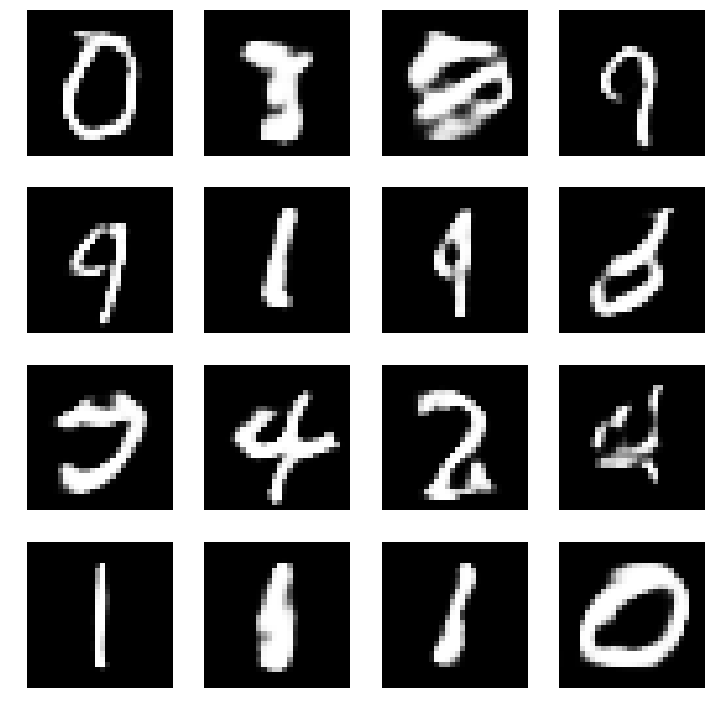

In [9]:
# Train for 2000 epochs and save at 200 intervals
# print G images
# save images
mnist_dcgan.train(train_steps=2000, batch_size=256, save_interval=200)
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

0: [D loss: 0.694200, acc: 0.486328]  [A loss: 1.032304, acc: 0.000000]
1: [D loss: 0.665861, acc: 0.525391]  [A loss: 0.966823, acc: 0.000000]
2: [D loss: 0.602871, acc: 0.978516]  [A loss: 1.148097, acc: 0.000000]
3: [D loss: 0.519768, acc: 0.671875]  [A loss: 1.491733, acc: 0.000000]
4: [D loss: 0.562950, acc: 0.970703]  [A loss: 0.746627, acc: 0.292969]
5: [D loss: 0.952768, acc: 0.500000]  [A loss: 1.060897, acc: 0.000000]
6: [D loss: 0.464746, acc: 0.996094]  [A loss: 1.009413, acc: 0.000000]
7: [D loss: 0.417337, acc: 0.966797]  [A loss: 1.033287, acc: 0.000000]
8: [D loss: 0.464833, acc: 0.552734]  [A loss: 1.274700, acc: 0.000000]
9: [D loss: 0.420379, acc: 0.738281]  [A loss: 1.252419, acc: 0.000000]
10: [D loss: 0.428633, acc: 0.623047]  [A loss: 1.365008, acc: 0.000000]
11: [D loss: 0.388039, acc: 0.857422]  [A loss: 1.254597, acc: 0.000000]
12: [D loss: 0.423267, acc: 0.605469]  [A loss: 1.648377, acc: 0.000000]
13: [D loss: 0.338808, acc: 1.000000]  [A loss: 1.133146, acc

113: [D loss: 0.494028, acc: 0.875000]  [A loss: 0.788664, acc: 0.343750]
114: [D loss: 0.710518, acc: 0.500000]  [A loss: 1.889697, acc: 0.000000]
115: [D loss: 0.469649, acc: 0.884766]  [A loss: 1.025986, acc: 0.132812]
116: [D loss: 0.619871, acc: 0.544922]  [A loss: 1.839863, acc: 0.000000]
117: [D loss: 0.499653, acc: 0.833984]  [A loss: 1.008168, acc: 0.074219]
118: [D loss: 0.653431, acc: 0.521484]  [A loss: 2.117540, acc: 0.000000]
119: [D loss: 0.494996, acc: 0.861328]  [A loss: 0.832081, acc: 0.304688]
120: [D loss: 0.737476, acc: 0.505859]  [A loss: 2.150315, acc: 0.000000]
121: [D loss: 0.545545, acc: 0.796875]  [A loss: 0.706036, acc: 0.496094]
122: [D loss: 0.813466, acc: 0.500000]  [A loss: 1.974588, acc: 0.000000]
123: [D loss: 0.532366, acc: 0.798828]  [A loss: 0.820588, acc: 0.304688]
124: [D loss: 0.693681, acc: 0.509766]  [A loss: 1.898536, acc: 0.000000]
125: [D loss: 0.528870, acc: 0.816406]  [A loss: 0.891347, acc: 0.183594]
126: [D loss: 0.705535, acc: 0.517578]

224: [D loss: 0.751613, acc: 0.500000]  [A loss: 1.439034, acc: 0.003906]
225: [D loss: 0.585584, acc: 0.734375]  [A loss: 0.868643, acc: 0.238281]
226: [D loss: 0.663381, acc: 0.564453]  [A loss: 1.463061, acc: 0.003906]
227: [D loss: 0.600621, acc: 0.708984]  [A loss: 0.841085, acc: 0.277344]
228: [D loss: 0.662377, acc: 0.544922]  [A loss: 1.490902, acc: 0.003906]
229: [D loss: 0.596896, acc: 0.736328]  [A loss: 0.863168, acc: 0.246094]
230: [D loss: 0.677751, acc: 0.539062]  [A loss: 1.645102, acc: 0.000000]
231: [D loss: 0.607533, acc: 0.703125]  [A loss: 0.715926, acc: 0.460938]
232: [D loss: 0.737065, acc: 0.513672]  [A loss: 1.692635, acc: 0.000000]
233: [D loss: 0.608111, acc: 0.685547]  [A loss: 0.694119, acc: 0.542969]
234: [D loss: 0.740162, acc: 0.507812]  [A loss: 1.598205, acc: 0.000000]
235: [D loss: 0.620001, acc: 0.669922]  [A loss: 0.729496, acc: 0.433594]
236: [D loss: 0.696854, acc: 0.527344]  [A loss: 1.419046, acc: 0.011719]
237: [D loss: 0.604087, acc: 0.697266]

335: [D loss: 0.651980, acc: 0.646484]  [A loss: 0.739527, acc: 0.406250]
336: [D loss: 0.701151, acc: 0.529297]  [A loss: 1.154433, acc: 0.007812]
337: [D loss: 0.672107, acc: 0.580078]  [A loss: 0.794970, acc: 0.265625]
338: [D loss: 0.693705, acc: 0.527344]  [A loss: 1.079484, acc: 0.007812]
339: [D loss: 0.657940, acc: 0.630859]  [A loss: 0.775278, acc: 0.304688]
340: [D loss: 0.678773, acc: 0.535156]  [A loss: 1.129700, acc: 0.000000]
341: [D loss: 0.655561, acc: 0.636719]  [A loss: 0.802178, acc: 0.273438]
342: [D loss: 0.674229, acc: 0.550781]  [A loss: 1.124812, acc: 0.000000]
343: [D loss: 0.644975, acc: 0.628906]  [A loss: 0.795511, acc: 0.296875]
344: [D loss: 0.693886, acc: 0.525391]  [A loss: 1.180147, acc: 0.003906]
345: [D loss: 0.645244, acc: 0.658203]  [A loss: 0.691247, acc: 0.531250]
346: [D loss: 0.695883, acc: 0.535156]  [A loss: 1.277721, acc: 0.003906]
347: [D loss: 0.665456, acc: 0.613281]  [A loss: 0.640741, acc: 0.664062]
348: [D loss: 0.719706, acc: 0.517578]

446: [D loss: 0.695868, acc: 0.521484]  [A loss: 1.095983, acc: 0.023438]
447: [D loss: 0.663285, acc: 0.605469]  [A loss: 0.772273, acc: 0.328125]
448: [D loss: 0.694941, acc: 0.548828]  [A loss: 1.105670, acc: 0.015625]
449: [D loss: 0.669872, acc: 0.583984]  [A loss: 0.744164, acc: 0.410156]
450: [D loss: 0.697098, acc: 0.513672]  [A loss: 1.080040, acc: 0.031250]
451: [D loss: 0.665019, acc: 0.613281]  [A loss: 0.755995, acc: 0.324219]
452: [D loss: 0.697696, acc: 0.537109]  [A loss: 1.081200, acc: 0.011719]
453: [D loss: 0.684594, acc: 0.539062]  [A loss: 0.770299, acc: 0.324219]
454: [D loss: 0.691547, acc: 0.533203]  [A loss: 1.099787, acc: 0.011719]
455: [D loss: 0.666062, acc: 0.580078]  [A loss: 0.704376, acc: 0.468750]
456: [D loss: 0.707070, acc: 0.533203]  [A loss: 1.114911, acc: 0.000000]
457: [D loss: 0.671142, acc: 0.574219]  [A loss: 0.713688, acc: 0.453125]
458: [D loss: 0.719233, acc: 0.505859]  [A loss: 1.083932, acc: 0.046875]
459: [D loss: 0.684225, acc: 0.527344]

557: [D loss: 0.686281, acc: 0.554688]  [A loss: 0.948373, acc: 0.082031]
558: [D loss: 0.683907, acc: 0.556641]  [A loss: 0.868445, acc: 0.156250]
559: [D loss: 0.671923, acc: 0.583984]  [A loss: 0.908478, acc: 0.117188]
560: [D loss: 0.673320, acc: 0.576172]  [A loss: 0.894130, acc: 0.136719]
561: [D loss: 0.676965, acc: 0.546875]  [A loss: 0.924234, acc: 0.078125]
562: [D loss: 0.664125, acc: 0.595703]  [A loss: 0.942456, acc: 0.078125]
563: [D loss: 0.659469, acc: 0.625000]  [A loss: 0.943787, acc: 0.089844]
564: [D loss: 0.673313, acc: 0.595703]  [A loss: 0.943082, acc: 0.117188]
565: [D loss: 0.673950, acc: 0.585938]  [A loss: 0.917672, acc: 0.101562]
566: [D loss: 0.677601, acc: 0.568359]  [A loss: 0.862113, acc: 0.179688]
567: [D loss: 0.684559, acc: 0.574219]  [A loss: 1.002528, acc: 0.070312]
568: [D loss: 0.677909, acc: 0.582031]  [A loss: 0.775821, acc: 0.324219]
569: [D loss: 0.703443, acc: 0.507812]  [A loss: 1.218689, acc: 0.000000]
570: [D loss: 0.680672, acc: 0.546875]

668: [D loss: 0.657805, acc: 0.603516]  [A loss: 0.749349, acc: 0.371094]
669: [D loss: 0.685451, acc: 0.556641]  [A loss: 0.966708, acc: 0.089844]
670: [D loss: 0.666681, acc: 0.582031]  [A loss: 0.812413, acc: 0.316406]
671: [D loss: 0.675448, acc: 0.552734]  [A loss: 0.996126, acc: 0.066406]
672: [D loss: 0.651440, acc: 0.648438]  [A loss: 0.822841, acc: 0.285156]
673: [D loss: 0.676460, acc: 0.560547]  [A loss: 0.992800, acc: 0.066406]
674: [D loss: 0.660225, acc: 0.623047]  [A loss: 0.839319, acc: 0.246094]
675: [D loss: 0.696724, acc: 0.529297]  [A loss: 1.064316, acc: 0.027344]
676: [D loss: 0.669199, acc: 0.597656]  [A loss: 0.767405, acc: 0.339844]
677: [D loss: 0.696256, acc: 0.539062]  [A loss: 1.087916, acc: 0.027344]
678: [D loss: 0.666481, acc: 0.603516]  [A loss: 0.771740, acc: 0.355469]
679: [D loss: 0.681460, acc: 0.554688]  [A loss: 1.044684, acc: 0.046875]
680: [D loss: 0.653768, acc: 0.640625]  [A loss: 0.814191, acc: 0.265625]
681: [D loss: 0.669018, acc: 0.585938]

779: [D loss: 0.649354, acc: 0.644531]  [A loss: 0.856061, acc: 0.214844]
780: [D loss: 0.678660, acc: 0.544922]  [A loss: 1.003192, acc: 0.070312]
781: [D loss: 0.644289, acc: 0.632812]  [A loss: 0.834380, acc: 0.230469]
782: [D loss: 0.706291, acc: 0.541016]  [A loss: 1.073040, acc: 0.039062]
783: [D loss: 0.651709, acc: 0.603516]  [A loss: 0.823086, acc: 0.292969]
784: [D loss: 0.678026, acc: 0.548828]  [A loss: 1.009800, acc: 0.035156]
785: [D loss: 0.660728, acc: 0.623047]  [A loss: 0.825507, acc: 0.269531]
786: [D loss: 0.680481, acc: 0.576172]  [A loss: 0.953780, acc: 0.144531]
787: [D loss: 0.677624, acc: 0.580078]  [A loss: 0.928211, acc: 0.140625]
788: [D loss: 0.684026, acc: 0.566406]  [A loss: 0.960967, acc: 0.117188]
789: [D loss: 0.657052, acc: 0.609375]  [A loss: 0.848748, acc: 0.230469]
790: [D loss: 0.674399, acc: 0.570312]  [A loss: 1.080035, acc: 0.046875]
791: [D loss: 0.659646, acc: 0.621094]  [A loss: 0.792107, acc: 0.332031]
792: [D loss: 0.688831, acc: 0.546875]

890: [D loss: 0.682241, acc: 0.554688]  [A loss: 0.925907, acc: 0.125000]
891: [D loss: 0.664953, acc: 0.615234]  [A loss: 0.886053, acc: 0.175781]
892: [D loss: 0.661025, acc: 0.607422]  [A loss: 0.909748, acc: 0.132812]
893: [D loss: 0.665999, acc: 0.599609]  [A loss: 0.909896, acc: 0.144531]
894: [D loss: 0.653121, acc: 0.611328]  [A loss: 0.934701, acc: 0.125000]
895: [D loss: 0.680661, acc: 0.574219]  [A loss: 0.891031, acc: 0.117188]
896: [D loss: 0.658723, acc: 0.582031]  [A loss: 0.914990, acc: 0.152344]
897: [D loss: 0.683039, acc: 0.578125]  [A loss: 0.964974, acc: 0.093750]
898: [D loss: 0.681542, acc: 0.570312]  [A loss: 0.896276, acc: 0.144531]
899: [D loss: 0.665017, acc: 0.611328]  [A loss: 0.946750, acc: 0.121094]
900: [D loss: 0.668047, acc: 0.582031]  [A loss: 0.986173, acc: 0.078125]
901: [D loss: 0.680727, acc: 0.554688]  [A loss: 0.795905, acc: 0.335938]
902: [D loss: 0.695163, acc: 0.548828]  [A loss: 1.048768, acc: 0.058594]
903: [D loss: 0.650990, acc: 0.617188]

1003: [D loss: 0.661041, acc: 0.583984]  [A loss: 0.803825, acc: 0.316406]
1004: [D loss: 0.678530, acc: 0.564453]  [A loss: 0.957038, acc: 0.144531]
1005: [D loss: 0.663567, acc: 0.587891]  [A loss: 0.848907, acc: 0.222656]
1006: [D loss: 0.666694, acc: 0.583984]  [A loss: 0.902692, acc: 0.195312]
1007: [D loss: 0.688201, acc: 0.542969]  [A loss: 0.938418, acc: 0.167969]
1008: [D loss: 0.680986, acc: 0.535156]  [A loss: 0.890825, acc: 0.171875]
1009: [D loss: 0.670293, acc: 0.593750]  [A loss: 0.901332, acc: 0.156250]
1010: [D loss: 0.667116, acc: 0.576172]  [A loss: 0.905675, acc: 0.171875]
1011: [D loss: 0.681284, acc: 0.582031]  [A loss: 1.027736, acc: 0.085938]
1012: [D loss: 0.685420, acc: 0.566406]  [A loss: 0.740609, acc: 0.441406]
1013: [D loss: 0.690468, acc: 0.541016]  [A loss: 1.036239, acc: 0.093750]
1014: [D loss: 0.654285, acc: 0.619141]  [A loss: 0.780096, acc: 0.355469]
1015: [D loss: 0.726552, acc: 0.533203]  [A loss: 1.008122, acc: 0.054688]
1016: [D loss: 0.681858, 

1113: [D loss: 0.680012, acc: 0.556641]  [A loss: 0.787923, acc: 0.316406]
1114: [D loss: 0.691817, acc: 0.531250]  [A loss: 0.934056, acc: 0.117188]
1115: [D loss: 0.677620, acc: 0.585938]  [A loss: 0.848876, acc: 0.246094]
1116: [D loss: 0.665551, acc: 0.572266]  [A loss: 0.913668, acc: 0.183594]
1117: [D loss: 0.675416, acc: 0.574219]  [A loss: 0.910979, acc: 0.148438]
1118: [D loss: 0.682997, acc: 0.560547]  [A loss: 0.908549, acc: 0.183594]
1119: [D loss: 0.667094, acc: 0.574219]  [A loss: 0.892134, acc: 0.187500]
1120: [D loss: 0.667833, acc: 0.605469]  [A loss: 0.848743, acc: 0.242188]
1121: [D loss: 0.666757, acc: 0.583984]  [A loss: 0.969759, acc: 0.093750]
1122: [D loss: 0.663381, acc: 0.595703]  [A loss: 0.882621, acc: 0.179688]
1123: [D loss: 0.665258, acc: 0.603516]  [A loss: 0.948515, acc: 0.132812]
1124: [D loss: 0.668065, acc: 0.576172]  [A loss: 0.926505, acc: 0.132812]
1125: [D loss: 0.675066, acc: 0.582031]  [A loss: 0.914274, acc: 0.164062]
1126: [D loss: 0.685048, 

1224: [D loss: 0.683184, acc: 0.539062]  [A loss: 0.885613, acc: 0.144531]
1225: [D loss: 0.684008, acc: 0.560547]  [A loss: 0.879113, acc: 0.187500]
1226: [D loss: 0.674342, acc: 0.583984]  [A loss: 0.846523, acc: 0.257812]
1227: [D loss: 0.692954, acc: 0.560547]  [A loss: 0.884692, acc: 0.207031]
1228: [D loss: 0.672267, acc: 0.597656]  [A loss: 0.926516, acc: 0.125000]
1229: [D loss: 0.666722, acc: 0.591797]  [A loss: 0.895880, acc: 0.183594]
1230: [D loss: 0.677584, acc: 0.580078]  [A loss: 0.824168, acc: 0.265625]
1231: [D loss: 0.679388, acc: 0.591797]  [A loss: 0.995623, acc: 0.101562]
1232: [D loss: 0.665599, acc: 0.591797]  [A loss: 0.780409, acc: 0.343750]
1233: [D loss: 0.686266, acc: 0.558594]  [A loss: 1.014348, acc: 0.093750]
1234: [D loss: 0.688867, acc: 0.558594]  [A loss: 0.771578, acc: 0.367188]
1235: [D loss: 0.683300, acc: 0.560547]  [A loss: 1.063742, acc: 0.062500]
1236: [D loss: 0.677868, acc: 0.560547]  [A loss: 0.773140, acc: 0.378906]
1237: [D loss: 0.693779, 

1335: [D loss: 0.670589, acc: 0.613281]  [A loss: 0.815419, acc: 0.300781]
1336: [D loss: 0.677126, acc: 0.583984]  [A loss: 0.906730, acc: 0.171875]
1337: [D loss: 0.679404, acc: 0.570312]  [A loss: 0.828450, acc: 0.269531]
1338: [D loss: 0.684878, acc: 0.578125]  [A loss: 0.910521, acc: 0.199219]
1339: [D loss: 0.671132, acc: 0.568359]  [A loss: 0.880848, acc: 0.179688]
1340: [D loss: 0.685046, acc: 0.556641]  [A loss: 0.913218, acc: 0.152344]
1341: [D loss: 0.679125, acc: 0.574219]  [A loss: 0.898885, acc: 0.156250]
1342: [D loss: 0.674678, acc: 0.583984]  [A loss: 0.945899, acc: 0.117188]
1343: [D loss: 0.682929, acc: 0.576172]  [A loss: 0.766496, acc: 0.363281]
1344: [D loss: 0.704774, acc: 0.552734]  [A loss: 0.993266, acc: 0.089844]
1345: [D loss: 0.680700, acc: 0.611328]  [A loss: 0.744298, acc: 0.394531]
1346: [D loss: 0.694825, acc: 0.539062]  [A loss: 1.034510, acc: 0.058594]
1347: [D loss: 0.686143, acc: 0.546875]  [A loss: 0.692173, acc: 0.542969]
1348: [D loss: 0.704148, 

1446: [D loss: 0.677430, acc: 0.576172]  [A loss: 0.879954, acc: 0.179688]
1447: [D loss: 0.694714, acc: 0.523438]  [A loss: 0.843464, acc: 0.230469]
1448: [D loss: 0.689571, acc: 0.537109]  [A loss: 0.925799, acc: 0.144531]
1449: [D loss: 0.682817, acc: 0.541016]  [A loss: 0.854862, acc: 0.253906]
1450: [D loss: 0.697332, acc: 0.537109]  [A loss: 0.916327, acc: 0.121094]
1451: [D loss: 0.674875, acc: 0.595703]  [A loss: 0.816156, acc: 0.289062]
1452: [D loss: 0.686505, acc: 0.576172]  [A loss: 0.893652, acc: 0.167969]
1453: [D loss: 0.679141, acc: 0.576172]  [A loss: 0.858643, acc: 0.214844]
1454: [D loss: 0.676621, acc: 0.556641]  [A loss: 0.872283, acc: 0.195312]
1455: [D loss: 0.668277, acc: 0.572266]  [A loss: 0.804056, acc: 0.308594]
1456: [D loss: 0.703430, acc: 0.560547]  [A loss: 0.941838, acc: 0.128906]
1457: [D loss: 0.682525, acc: 0.542969]  [A loss: 0.748304, acc: 0.414062]
1458: [D loss: 0.686142, acc: 0.533203]  [A loss: 1.001927, acc: 0.066406]
1459: [D loss: 0.683476, 

1557: [D loss: 0.704076, acc: 0.515625]  [A loss: 0.989431, acc: 0.082031]
1558: [D loss: 0.671928, acc: 0.609375]  [A loss: 0.753937, acc: 0.410156]
1559: [D loss: 0.709161, acc: 0.509766]  [A loss: 0.933502, acc: 0.117188]
1560: [D loss: 0.675668, acc: 0.583984]  [A loss: 0.716697, acc: 0.457031]
1561: [D loss: 0.709270, acc: 0.507812]  [A loss: 0.987435, acc: 0.085938]
1562: [D loss: 0.679402, acc: 0.587891]  [A loss: 0.767321, acc: 0.351562]
1563: [D loss: 0.694827, acc: 0.548828]  [A loss: 0.911744, acc: 0.191406]
1564: [D loss: 0.685579, acc: 0.550781]  [A loss: 0.821210, acc: 0.281250]
1565: [D loss: 0.688139, acc: 0.548828]  [A loss: 0.917943, acc: 0.136719]
1566: [D loss: 0.686848, acc: 0.552734]  [A loss: 0.792130, acc: 0.328125]
1567: [D loss: 0.686418, acc: 0.578125]  [A loss: 0.921604, acc: 0.160156]
1568: [D loss: 0.679306, acc: 0.585938]  [A loss: 0.783869, acc: 0.343750]
1569: [D loss: 0.691942, acc: 0.541016]  [A loss: 0.914762, acc: 0.105469]
1570: [D loss: 0.678223, 

1668: [D loss: 0.687210, acc: 0.535156]  [A loss: 0.746120, acc: 0.425781]
1669: [D loss: 0.696228, acc: 0.537109]  [A loss: 1.003473, acc: 0.093750]
1670: [D loss: 0.696481, acc: 0.564453]  [A loss: 0.706786, acc: 0.507812]
1671: [D loss: 0.714446, acc: 0.529297]  [A loss: 0.976400, acc: 0.062500]
1672: [D loss: 0.688865, acc: 0.539062]  [A loss: 0.711779, acc: 0.507812]
1673: [D loss: 0.696474, acc: 0.527344]  [A loss: 0.946872, acc: 0.109375]
1674: [D loss: 0.689790, acc: 0.560547]  [A loss: 0.757815, acc: 0.410156]
1675: [D loss: 0.688891, acc: 0.587891]  [A loss: 0.871601, acc: 0.203125]
1676: [D loss: 0.687969, acc: 0.539062]  [A loss: 0.804297, acc: 0.281250]
1677: [D loss: 0.689564, acc: 0.544922]  [A loss: 0.818566, acc: 0.257812]
1678: [D loss: 0.675665, acc: 0.564453]  [A loss: 0.853838, acc: 0.207031]
1679: [D loss: 0.674394, acc: 0.578125]  [A loss: 0.793457, acc: 0.300781]
1680: [D loss: 0.682813, acc: 0.554688]  [A loss: 0.885586, acc: 0.195312]
1681: [D loss: 0.689964, 

1779: [D loss: 0.696246, acc: 0.539062]  [A loss: 0.820793, acc: 0.281250]
1780: [D loss: 0.703716, acc: 0.531250]  [A loss: 0.846251, acc: 0.234375]
1781: [D loss: 0.688310, acc: 0.568359]  [A loss: 0.957434, acc: 0.121094]
1782: [D loss: 0.689357, acc: 0.519531]  [A loss: 0.778299, acc: 0.324219]
1783: [D loss: 0.694052, acc: 0.560547]  [A loss: 0.922227, acc: 0.167969]
1784: [D loss: 0.693688, acc: 0.527344]  [A loss: 0.810543, acc: 0.300781]
1785: [D loss: 0.688800, acc: 0.541016]  [A loss: 0.900660, acc: 0.195312]
1786: [D loss: 0.677842, acc: 0.578125]  [A loss: 0.760650, acc: 0.406250]
1787: [D loss: 0.696452, acc: 0.529297]  [A loss: 0.960737, acc: 0.117188]
1788: [D loss: 0.705940, acc: 0.519531]  [A loss: 0.774141, acc: 0.363281]
1789: [D loss: 0.695086, acc: 0.542969]  [A loss: 0.954032, acc: 0.105469]
1790: [D loss: 0.683456, acc: 0.564453]  [A loss: 0.746494, acc: 0.414062]
1791: [D loss: 0.700196, acc: 0.552734]  [A loss: 1.012647, acc: 0.066406]
1792: [D loss: 0.677636, 

1890: [D loss: 0.704540, acc: 0.535156]  [A loss: 1.040315, acc: 0.042969]
1891: [D loss: 0.685454, acc: 0.558594]  [A loss: 0.645125, acc: 0.644531]
1892: [D loss: 0.730357, acc: 0.517578]  [A loss: 1.014222, acc: 0.093750]
1893: [D loss: 0.704869, acc: 0.521484]  [A loss: 0.751087, acc: 0.433594]
1894: [D loss: 0.697337, acc: 0.511719]  [A loss: 0.947355, acc: 0.105469]
1895: [D loss: 0.685187, acc: 0.550781]  [A loss: 0.839423, acc: 0.234375]
1896: [D loss: 0.687570, acc: 0.556641]  [A loss: 0.814458, acc: 0.300781]
1897: [D loss: 0.686949, acc: 0.542969]  [A loss: 0.889548, acc: 0.222656]
1898: [D loss: 0.681531, acc: 0.554688]  [A loss: 0.827852, acc: 0.316406]
1899: [D loss: 0.689716, acc: 0.560547]  [A loss: 0.905606, acc: 0.164062]
1900: [D loss: 0.673032, acc: 0.574219]  [A loss: 0.824635, acc: 0.253906]
1901: [D loss: 0.697534, acc: 0.546875]  [A loss: 0.896554, acc: 0.152344]
1902: [D loss: 0.683116, acc: 0.556641]  [A loss: 0.842644, acc: 0.273438]
1903: [D loss: 0.690019, 

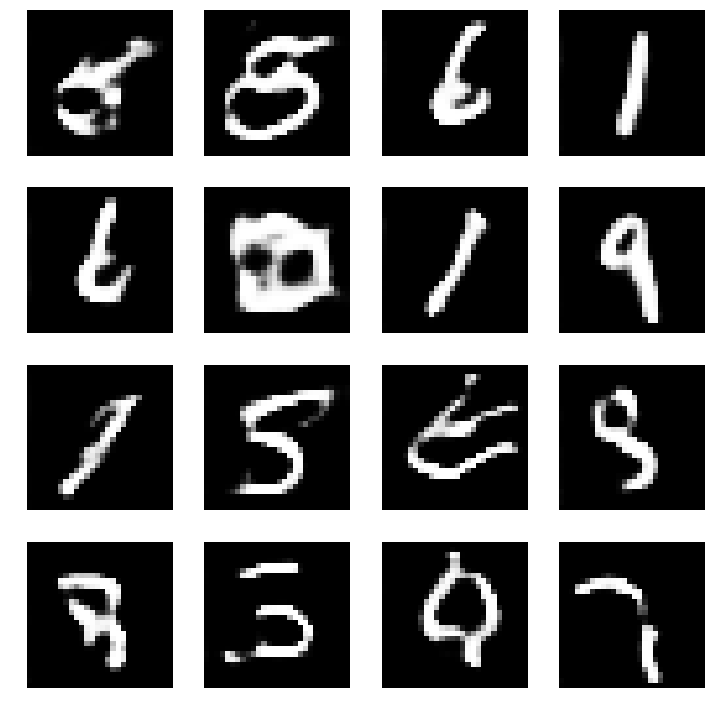

In [12]:
# Train for 5000 epochs and save at 500 intervals
# print G images
# save images
mnist_dcgan.train(train_steps=2000, batch_size=256, save_interval=500)
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)